In [2]:
import numpy as np
import cupy as cp
import os
import math
import matplotlib.pyplot as plt
import time
from PIL import Image
import nibabel as nb
from skimage.measure import block_reduce
from skimage import filters
from scipy.fft import fftn, fftshift
import ct_basic as basic
import HeadCT_motion_correction_PAR.functions_collection as ff
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform
import HeadCT_motion_correction_PAR.Data_processing as processing
import HeadCT_motion_correction_PAR.STN.model_components as compo

import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy as numpy_projector
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan
import ct_projector.projector.cupy.parallel as ct_para
import ct_projector.projector.numpy.parallel as numpy_para

In [55]:
# load a sample CT image
filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000006/MO001A000007/img-nii-0.7/img.nii.gz'
img,spacing,affine = basic.basic_image_processing(filename)
print(img.shape, spacing)

save_folder = '/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/'

# img_ds = np.copy(img[0:60,...])
img_ds = np.copy(img[60:100,...])
img_ds = ff.insert_blank_slices(img_ds , insert_to_which_direction = 'x', begin_blank_slice_num = 10, end_blank_slice_num = 10)
img_ds = img_ds[np.newaxis, ...]
print(img_ds.shape)
truth = img_ds[0,...]/ 0.019 * 1000 - 1024

(256, 234, 234) [0.70075274 1.         1.        ]
(1, 60, 234, 234)


In [56]:
nb.save(nb.Nifti1Image(np.rollaxis(truth.astype(np.int32),0,3),affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','test_sinograms/static_HR.nii.gz'))

# prepare some sinograms

In [44]:
# generate and save sinograms
# do the forward projection of moving object
# def generate_and_save_sinograms_linear_motion(img,total_angle, translation, rotation, file_name , sga = 0, load_file = False, geometry = 'fan', total_view_num = 1000, increment = 20):
#     start_view = 0
#     end_view = total_view_num
#     slice_num = None
  
#     projector = basic.define_forward_projector(img,spacing,total_view_num)
#     angles = ff.get_angles_zc(total_view_num, total_angle,sga)
#     if load_file == False:
#         sinogram = basic.fp_w_linear_motion(img, projector, angles, translation, rotation, start_view, end_view,slice_num, increment, geometry)

#         np.save(file_name, sinogram)
    
#     else:
#         sinogram = np.load(file_name, allow_pickle = True)
#     return angles, sinogram, total_angle, translation, rotation, geometry, projector

def generate_and_save_sinograms_spline_motion(img, total_angle, amplitude_tx, amplitude_ty, amplitude_tz, amplitude_rx, amplitude_ry, amplitude_rz, file_name , sga, load_file = False, geometry = 'fan', total_view_num = 1000, increment = 100, gantry_rotation_time = 500):
    t = np.linspace(gantry_rotation_time / 10,gantry_rotation_time, 10, endpoint=True)
    spline_tx = transform.interp_func(t, np.asarray(amplitude_tx))
    spline_ty = transform.interp_func(t, np.asarray(amplitude_ty))
    spline_tz = transform.interp_func(t, np.asarray(amplitude_tz))
    spline_rx = transform.interp_func(t, np.asarray(amplitude_rx))
    spline_ry = transform.interp_func(t, np.asarray(amplitude_ry))
    spline_rz = transform.interp_func(t, np.asarray(amplitude_rz))

    print(geometry)
    projector = basic.define_forward_projector(img,spacing,total_view_num)
    angles = ff.get_angles_zc(total_view_num, total_angle, sga)

    if load_file == False:
        sinogram = basic.fp_w_spline_motion_model(img, projector, angles, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, total_view = total_view_num, gantry_rotation_time = 500, slice_num = None, increment = increment, order = 3)

        np.save(file_name, sinogram)
    else:
        sinogram = np.load(file_name, allow_pickle = True)

    return angles, sinogram, total_angle, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, projector


In [57]:
amplitude_tx = np.linspace(0,0,10)
amplitude_ty = np.linspace(0,0,10)
amplitude_tz = np.linspace(0,0,10)
amplitude_rx = np.linspace(0.4/180 * np.pi ,4/180*np.pi,10)
amplitude_ry = np.linspace(0,0/180*np.pi,10)
amplitude_rz = np.linspace(0.4/180 * np.pi ,4/180*np.pi,10)
total_view_num = 1000
increment = 100
gantry_rotation_time = 500

file_name = os.path.join(save_folder,'spline1.npy')
geometry = 'fan'
sga = 0
load_file = False

# make sinogram
angles, sinogram, total_angle, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, projector = generate_and_save_sinograms_spline_motion(img_ds, 360, amplitude_tx, amplitude_ty, amplitude_tz, amplitude_rx, amplitude_ry, amplitude_rz, file_name , sga = sga, load_file = load_file, geometry = geometry, total_view_num = total_view_num, increment = increment)

fan
t:  50.0  motion:  [array([0.]), array([0.]), array([0.])] [array([0.4]), array([0.4]), array([0.])]
t:  100.0  motion:  [array([0.]), array([0.]), array([0.])] [array([0.8]), array([0.8]), array([0.])]
t:  150.0  motion:  [array([0.]), array([0.]), array([0.])] [array([1.2]), array([1.2]), array([0.])]
t:  200.0  motion:  [array([0.]), array([0.]), array([0.])] [array([1.6]), array([1.6]), array([0.])]
t:  250.0  motion:  [array([0.]), array([0.]), array([0.])] [array([2.]), array([2.]), array([0.])]
t:  300.0  motion:  [array([0.]), array([0.]), array([0.])] [array([2.4]), array([2.4]), array([0.])]
t:  350.0  motion:  [array([0.]), array([0.]), array([0.])] [array([2.8]), array([2.8]), array([0.])]
t:  400.0  motion:  [array([0.]), array([0.]), array([0.])] [array([3.2]), array([3.2]), array([0.])]
t:  450.0  motion:  [array([0.]), array([0.]), array([0.])] [array([3.6]), array([3.6]), array([0.])]
t:  500.0  motion:  [array([0.]), array([0.]), array([0.])] [array([4.]), array([

# Make FBP

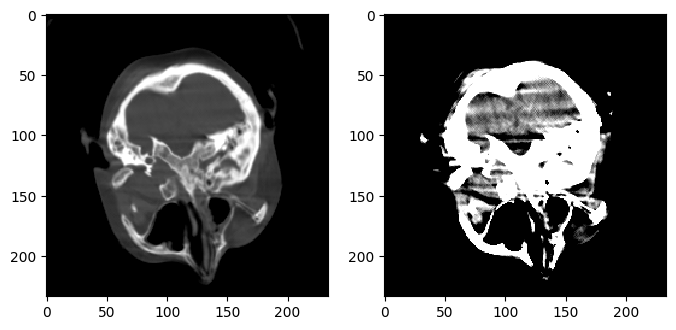

In [58]:
# directly make backprojection
fbp_projector = basic.backprojector(img_ds,spacing)
fbp = basic.filtered_backporjection(sinogram,angles,projector,fbp_projector, geometry, back_to_original_value = True)

truth = img_ds[0,...]/ 0.019 * 1000 - 1024

plt.figure(figsize = (8,4))
plt.subplot(121); plt.imshow(ff.set_window(fbp[15,...].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(fbp[15, :, :].T,50, 100), 'gray')
nb.save(nb.Nifti1Image(np.rollaxis(fbp.astype(np.int32),0,3),affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','test_sinograms/motion_HR.nii.gz'))

# use true sinogram to make PAR

0 [array([-0.]), array([-0.]), array([-0.])] [array([-0.4]), array([-0.4]), array([-0.])]
1 [array([-0.]), array([-0.]), array([-0.])] [array([-0.8]), array([-0.8]), array([-0.])]
2 [array([-0.]), array([-0.]), array([-0.])] [array([-1.2]), array([-1.2]), array([-0.])]
3 [array([-0.]), array([-0.]), array([-0.])] [array([-1.6]), array([-1.6]), array([-0.])]
4 [array([-0.]), array([-0.]), array([-0.])] [array([-2.]), array([-2.]), array([-0.])]
5 [array([-0.]), array([-0.]), array([-0.])] [array([-2.4]), array([-2.4]), array([-0.])]
6 [array([-0.]), array([-0.]), array([-0.])] [array([-2.8]), array([-2.8]), array([-0.])]
7 [array([-0.]), array([-0.]), array([-0.])] [array([-3.2]), array([-3.2]), array([-0.])]
8 [array([-0.]), array([-0.]), array([-0.])] [array([-3.6]), array([-3.6]), array([-0.])]
9 [array([-0.]), array([-0.]), array([-0.])] [array([-4.]), array([-4.]), array([-0.])]


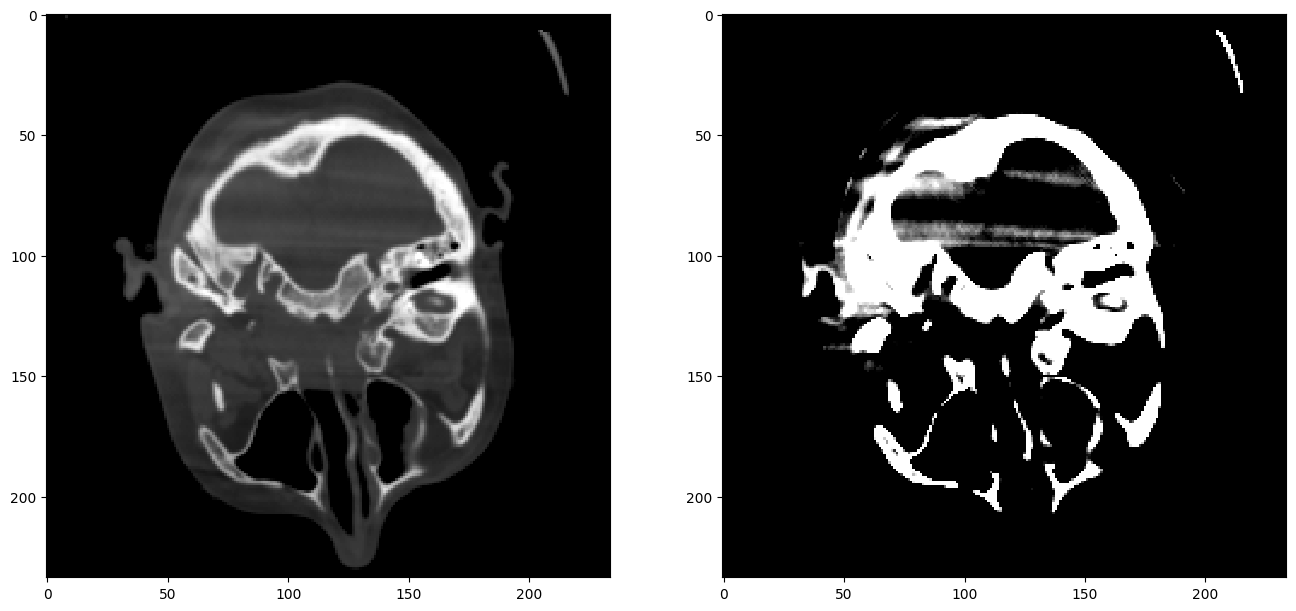

In [59]:
total_views = 1000
gantry_time = 500
# define how many PARs you want to make:
K = 10
# define use whole or half sinogram?
use = 'whole'

if use[0] == 'w':
    sinogram2 = np.copy(sinogram)
    angles2 = np.copy(angles)
    time2 = gantry_time
    
else:
    sinogram2 = sinogram[:, 0: sinogram.shape[1]//2, :, :]
    angles2 = angles[0: sinogram.shape[1]//2]
    time2 = gantry_time/2

# define the time window for each PAR
times = np.linspace(time2/K, time2, K)
    
projector2 = basic.define_forward_projector(img_ds,spacing,sinogram.shape[1])
fbp_projector2 = basic.backprojector(img_ds,spacing)

# divide sinogram:
sinogram_segments,  num_angles_in_one_segment, segment_indexes = basic.divide_sinogram_direct_num(sinogram2, K , sinogram2.shape[1])

##### IMPORTANT  - assign weights to sinogram projection data according to in-plane rotation:
sinogram_weighted, weights = transform.weighted_projection_due_to_rotation(sinogram_segments, segment_indexes, spline_rz, total_views, K,times, angles, sga, use_affine_transform = True)

# make PAR:
final_par = basic.make_PAR_new(sinogram_weighted, segment_indexes,  angles2, img_ds[0,...].shape, projector2, fbp_projector2, geometry = geometry, back_to_original_value=False)

# apply ground truth motion:
PAR_transformed_true_sinogram = np.copy(final_par)
for j in range(0,PAR_transformed_true_sinogram.shape[0]):
    t_end =[times[j]]
    translation_ = [-spline_tz(t_end) , -spline_tx(t_end), -spline_ty(t_end)]
    rotation_ = [-spline_rz(t_end), -spline_rx(t_end), -spline_ry(t_end)] 
    print(j, translation_, [rr/np.pi*180 for rr in rotation_])
    I = final_par[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix(translation_,rotation_,[1,1,1],I.shape, which_one_is_first = 'translation') # need to inverse the action
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix, order = 3, cval = np.min(I))

    PAR_transformed_true_sinogram[j,...] = img_new

PAR = np.sum(PAR_transformed_true_sinogram,axis=0) / (K) * 2
PAR = PAR / 0.019 * 1000 - 1024
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(ff.set_window(PAR[10,:,:].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(PAR[10,:,:].T,50, 100), 'gray')


In [60]:
nb.save(nb.Nifti1Image(np.rollaxis(PAR.astype(np.int32),0,3),affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','test_sinograms/PAR_corrected_HR.nii.gz'))

# use synthetic sinogram

(25, 70, 230, 230)
250


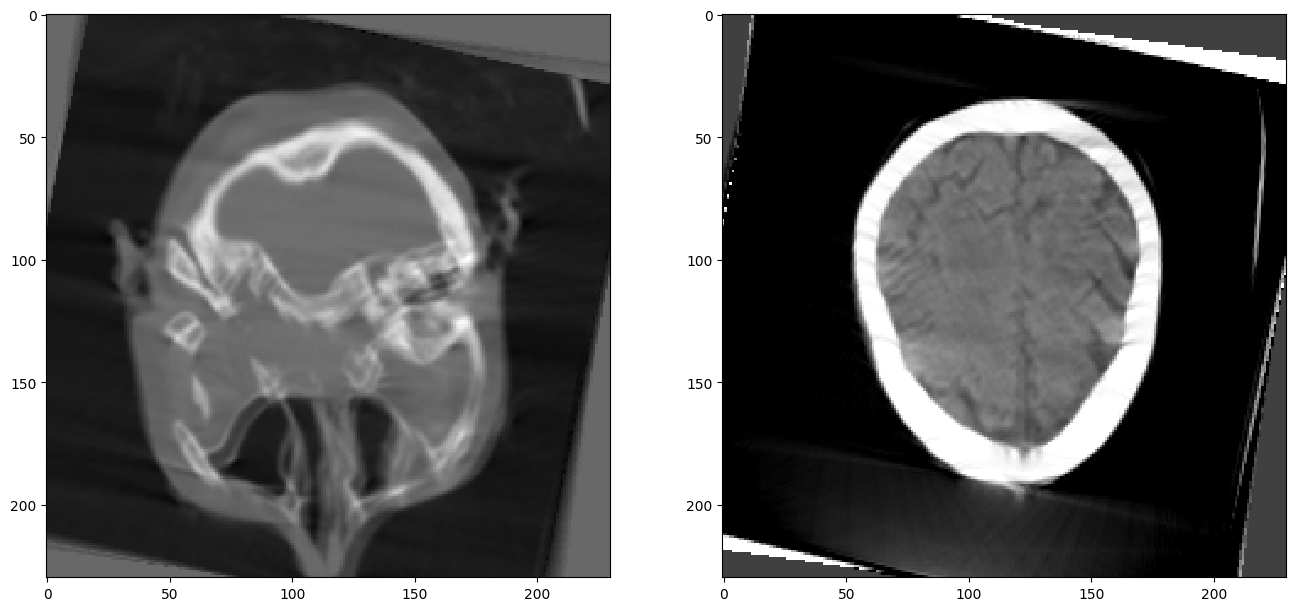

In [70]:
# do forward projection of motion image
motion_img = (fbp.astype(np.float32) + 1024) / 1000 * 0.019; motion_img[motion_img < 0] = 0; motion_img = motion_img[np.newaxis,...]

# define the angle interval you are going to use for synthetic sinogram
angle_interval = 180
# define the number of views 
view_num = sinogram.shape[1]

synthetic_angles = ff.get_angles_zc(view_num, angle_interval,0)
synthetic_projector = basic.define_forward_projector(motion_img,spacing,view_num)
synthetic_fbp_projector = basic.backprojector(img_ds,spacing)
synthetic_sinogram = basic.fp_static(motion_img,synthetic_angles,synthetic_projector, 'parallel')

# make PAR from synthetic sinogram
K = 12
sinogram_segments, center_angle_index, num_angles_in_one_segment, _ = basic.divide_sinogram(synthetic_sinogram, K , synthetic_sinogram.shape[1])
PAR_collections_synthetic = basic.make_PAR(sinogram_segments, K, center_angle_index, num_angles_in_one_segment, synthetic_angles, img_ds[0,...].shape, synthetic_projector, synthetic_fbp_projector, 'parallel')
print(PAR_collections_synthetic.shape)

# apply the known MVF to each PAR
PAR_transformed_synthetic = np.copy(PAR_collections_synthetic)
synthetic_time = [500 if total_angle//angle_interval == 1 else 250][0]
print(synthetic_time)

for j in range(0,PAR_transformed_synthetic.shape[0]):
    t_end = synthetic_time / (2*K+1) * (j+1)
    translation_ = [0 , -spline_x(t_end), -spline_y(t_end)]
    rotation_ = [-spline_r(t_end), 0, 0] 
    # print(j, translation_, rotation_)

    I = PAR_collections_synthetic[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix(translation_,rotation_,[1,1,1],I.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix,3,cval = np.min(img_ds))
    PAR_transformed_synthetic[j,...] = img_new

PAR_sum_synthetic = np.sum(PAR_transformed_synthetic,axis=0) / (2*K +1)
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(ff.set_window(PAR_sum_synthetic[15,...].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(PAR_sum_synthetic[50, :, :].T,50, 100), 'gray')

# try it on our clinical data

In [6]:
# load data
# ground truth
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000001/MO001A000001/static/image_data/recon_partial.nii.gz')
gt = nb.load(file_name).get_fdata()
image,spacing,affine = basic.basic_image_processing(file_name)
# motion image:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000001/MO001A000001/random_50/image_data/recon_partial_ds.nii.gz')
motion = nb.load(file_name).get_fdata()
image_motion,spacing_motion,affine_motion = basic.basic_image_processing(file_name)
# motion parameters:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000001/MO001A000001/random_50/motion_parameters.npy')
p = np.load(file_name,allow_pickle = True)
# PAR:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/PAR_2D_spline','MO101701M000001/MO001A000001/random_50/slice_0_to_15/ds/PARs_ds_crop.npy')
par = np.load(file_name,allow_pickle = True)

# ground truth image from PAR:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/PAR_2D_spline','MO101701M000001/MO001A000001/random_50/slice_0_to_15/image_by_PAR_true_MVF/image_by_PAR_ds.nii.gz')
truth = nb.load(file_name).get_fdata()

# sinogram:
file_name = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000001/MO001A000001/random_50/projection.nii.gz')
projection = nb.load(file_name).get_fdata()
projection = projection[:,:,np.newaxis,:];projection = projection[0:60,...]

In [4]:
# get motion parameters
tx= p[0,:][0]
ty= p[2,:][0]
r = p[4,:][0]

indexes,_,_ = basic.divide_sinogram_indexes(699, 1400)

spline_x = transform.interp_func(np.linspace(0,1,5),np.asarray(tx))
spline_y = transform.interp_func(np.linspace(0,1,5), np.asarray(ty))
spline_r = transform.interp_func(np.linspace(0,1,5), np.asarray(r))

tx_25 = [ spline_x(indexes[l][1]/1400) for l in range(0,indexes.shape[0])]
ty_25 = [ spline_y(indexes[l][1]/1400) for l in range(0,indexes.shape[0])]
r_25 = [ spline_r(indexes[l][1]/1400) for l in range(0,indexes.shape[0])]

do transformation using our script

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(


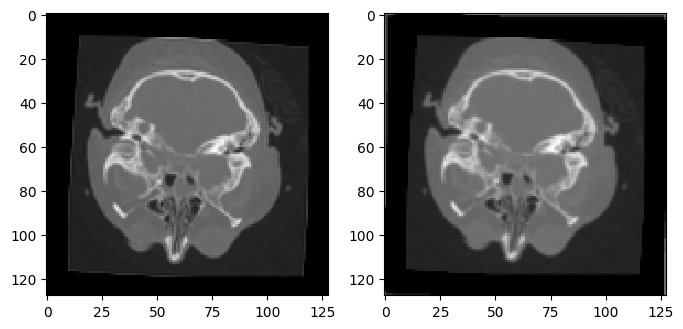

In [6]:
downsample = True

d = [1 if downsample == False else 2][0]
par_c = np.copy(par)
for j in range(0,par.shape[0]):
    I = par[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix([-tx_25[j]/d, -ty_25[j]/d,0],[0,0, -r_25[j]],[1,1,1],I.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix,3, cval = np.min(par))
    par_c[j,...] = img_new

par_c = np.sum(par_c,axis=0) / 25
plt.figure(figsize = (8,4))
plt.subplot(121); plt.imshow(ff.set_window(par_c[:,:,10].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(truth[:,:,10].T,500, 2000), 'gray')
# print(np.sum(par_c - gt[:,:,0:15]))


use Spatial transformer to do transformation (prepare for AI)

2023-01-02 21:56:48.485231: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-02 21:56:48.485373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-02 21:56:48.499285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 21:56:48.500397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.44GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-02 21:56:48.500427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-02 21:56:48.500470: I tensorflow/stream_executor/platform/defau

-67572364.11313818


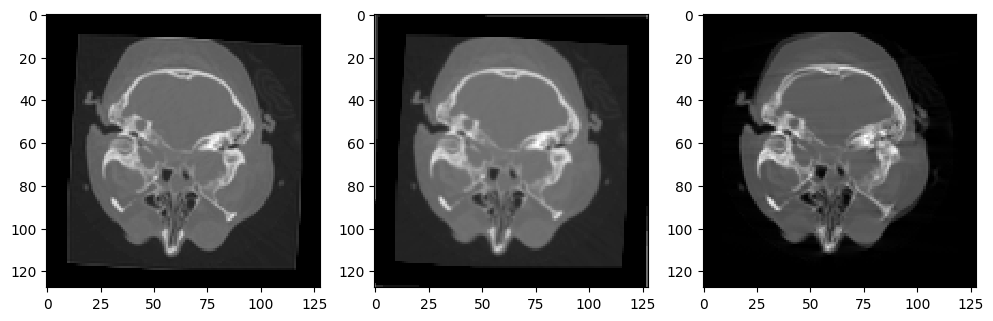

In [7]:
downsample = True
d = [1 if downsample == False else 2][0]
par_stn = np.copy(par)
for j in range(0,25):
    I = par[j,:,:,:]
    I = np.expand_dims(I[np.newaxis,...],axis = -1)
    I = np.transpose(I,[3,0,1,2,4])
    rr = float(r_25[j][0])
    translation = np.array([[1,0, -ty_25[j][0] / I.shape[3] * 2/ d], [0,1,-tx_25[j][0]/I.shape[2] * 2 /d ], [0,0,1]]) # STN has opposite coordinate as ours
    rotation = np.array([[math.cos(rr), -math.sin(rr), 0 ], [math.sin(rr), math.cos(rr), 0], [0,0,1]])

    transformation_matrix = np.dot(rotation, translation)
    matrix = transformation_matrix[0:2,:]
    
    a = [compo.BilinearInterpolation(I.shape[2],I.shape[3])([ii,matrix]) for ii in I]
    a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])
    par_stn[j,:,:,:] = np.squeeze(a)
par_stn = np.sum(par_stn,axis = 0) / 25

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(ff.set_window(par_c[:,:,10].T,500, 2000), 'gray')
plt.subplot(132); plt.imshow(ff.set_window(par_stn[:,:,10].T,500, 2000), 'gray')
plt.subplot(133); plt.imshow(ff.set_window(image_motion[10,:,:].T,500, 2000), 'gray')
print(np.sum(par_c - par_stn))

compare two methods:

69.72624355822211
379.0820703122245 254.51364196777342


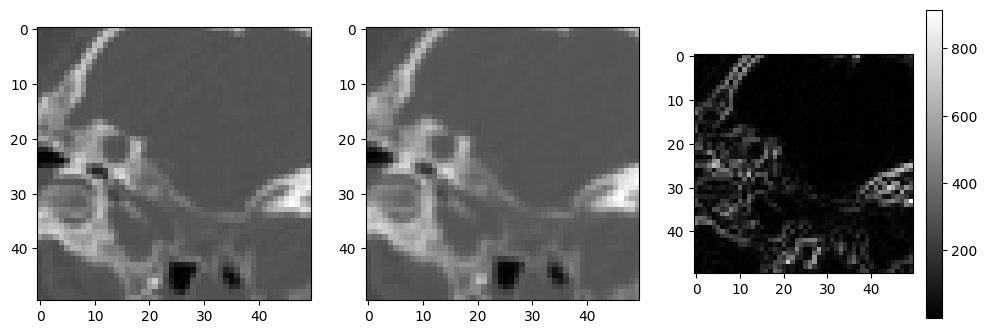

In [10]:
plt.figure(figsize = (12,4))
a = par_c[30:80,30:80,10]
b = par_stn[30:80,30:80,10]
plt.subplot(131); plt.imshow(a.T, 'gray')
plt.subplot(132); plt.imshow(b.T, 'gray')
delta = abs(a-b)
plt.subplot(133); plt.imshow(delta.T, 'gray')
plt.colorbar()
print(np.mean(abs(a-b)))

we found out that even with the true MVF, the image returned by PARs suffers from streaking artifacts (limited angle artifacts from PAR?)

let's investigate whether increasing PAR number can alleviate the problem.

In [16]:
image.shape

(0, 220, 220)

(1, 10, 220, 220)
[0 1]
[1 2]
[2 3]
[3 4]
[4 5]
[5 6]
[6 7]
[7 8]
[8 9]
[ 9 10]
[10 11]
[11 12]
[12 13]
[13 14]
[14 15]
[15 16]
[16 17]
[17 18]
[18 19]
[19 20]
[20 21]
[21 22]
[22 23]
[23 24]
[24 25]
[25 26]
[26 27]
[27 28]
[28 29]
[29 30]
[30 31]
[31 32]
[32 33]
[33 34]
[34 35]
[35 36]
[36 37]
[37 38]
[38 39]
[39 40]
[40 41]
[41 42]
[42 43]
[43 44]
[44 45]
[45 46]
[46 47]
[47 48]
[48 49]
[49 50]
[50 51]
[51 52]
[52 53]
[53 54]
[54 55]
[55 56]
[56 57]
[57 58]
[58 59]
[59 60]
[60 61]
[61 62]
[62 63]
[63 64]
[64 65]
[65 66]
[66 67]
[67 68]
[68 69]
[69 70]
[70 71]
[71 72]
[72 73]
[73 74]
[74 75]
[75 76]
[76 77]
[77 78]
[78 79]
[79 80]
[80 81]
[81 82]
[82 83]
[83 84]
[84 85]
[85 86]
[86 87]
[87 88]
[88 89]
[89 90]
[90 91]
[91 92]
[92 93]
[93 94]
[94 95]
[95 96]
[96 97]
[97 98]
[98 99]
[ 99 100]
[100 101]
[101 102]
[102 103]
[103 104]
[104 105]
[105 106]
[106 107]
[107 108]
[108 109]
[109 110]
[110 111]
[111 112]
[112 113]
[113 114]
[114 115]
[115 116]
[116 117]
[117 118]
[118 119]
[119 120

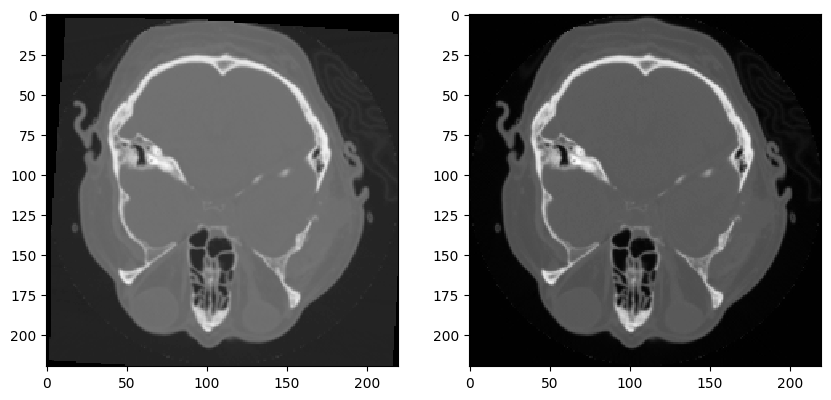

In [20]:
# let's try different number of PARs:
downsample = False
K = 699

img = image[10:20,...][np.newaxis,...]
print(img.shape)
projector = basic.define_forward_projector(img,spacing,1400)
fbp_projector = basic.backprojector(img,spacing)
angles = ff.get_angles_zc(1400, 360, 0)

# divide sinogram
sinogram_segments, center_angle_index, num_angles_in_one_segment, segment_indexes = basic.divide_sinogram_new(projection[10:20,...], K , 1400)
# make PAR
PAR_collections = basic.make_PAR_new(sinogram_segments,segment_indexes, angles, img[0,...].shape, projector, fbp_projector, 'fan')
print(PAR_collections.shape)
par1 = np.rollaxis(PAR_collections,1,4)

tx_25 = [ spline_x(segment_indexes[l][1]/1400) for l in range(0,segment_indexes.shape[0])]
ty_25 = [ spline_y(segment_indexes[l][1]/1400) for l in range(0,segment_indexes.shape[0])]
r_25 = [ spline_r(segment_indexes[l][1]/1400) for l in range(0,segment_indexes.shape[0])]

d = [1 if downsample == False else 2][0]
par_c = np.copy(par1)
for j in range(0,par1.shape[0]):
    if j % 50 == 0:
        print(j)
    I = par1[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix([-tx_25[j]/d, -ty_25[j]/d,0],[0,0, -r_25[j]],[1,1,1],I.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix,3, cval = np.min(par1))
    par_c[j,...] = img_new

par_c = np.sum(par_c,axis=0) / (par1.shape[0])
print(par_c.shape)

plt.figure(figsize = (10,5))
plt.subplot(121); plt.imshow(ff.set_window(par_c[:,:,5].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(gt[:,:,15].T,500, 2000), 'gray')

nb.save(nb.Nifti1Image(par_c,affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','par_'+str(2*K+1)+'.nii.gz'))
# mae_motion,_,_,rmse_motion,_, _ = ff.compare(par_c[:,:,35:50], gt[:,:,35:50] ,-10 )
# print(mae_motion, rmse_motion)

In [96]:
# compare mae
import HeadCT_motion_correction_PAR.Data_processing as dp
static = nb.load(os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000001/MO001A000001/static/image_data/recon_partial.nii.gz')).get_fdata()
motion = nb.load(os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline','MO101701M000001/MO001A000001/random_50/image_data/recon_partial.nii.gz')).get_fdata()
p = nb.load(os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','par_examples/par_1399.nii.gz')).get_fdata()
# p = p[:,:,10:20]
p = dp.cutoff_intensity(p,-1000)
static = static[:,:,10:20]
mae_motion,_,_,rmse_motion,_, _ = ff.compare(p,static ,0)
# mae_motion,_,_,rmse_motion,_, _ = ff.compare(p,static[:,:,10:20] ,-10 )
print(mae_motion, rmse_motion)

19.06335195159683 39.247625007609855


In [77]:
import pandas as pd
result = []
for i in range(0,d.shape[0]):
    for j in range(0,d.shape[1]):
        for z in np.arange(2):
            if static[i,j,z] <= -10:
                continue
            result.append([static[i,j,z], p[i,j,z]])
df = pd.DataFrame(result, columns = ['static', 'par'])
df.to_excel('/mnt/mount_zc_NAS/motion_correction/data/compare_par_11.xlsx', index = False)

Let's also investigate whether we can do augmentation (apply same M to PAR image and ground truth image)

In [10]:
downsample = True
d = [1 if downsample == False else 2][0]

# do augmentation on par
xx = 5.
yy = 5.
rr = 0.
# par_aug = np.copy(par)
# for j in range(0,25):
#     I = par[j,:,:,:]
#     I = np.expand_dims(I[np.newaxis,...],axis = -1)
#     I = np.transpose(I,[3,0,1,2,4])
#     translation = np.array([[1,0, xx / I.shape[3] * 2/ d], [0,1,yy/I.shape[2] * 2 /d ], [0,0,1]]) # STN has opposite coordinate as ours
#     rotation = np.array([[math.cos(rr), -math.sin(rr), 0 ], [math.sin(rr), math.cos(rr), 0], [0,0,1]])

#     transformation_matrix = np.dot(rotation, translation)
#     matrix = transformation_matrix[0:2,:]
    
#     a = [compo.BilinearInterpolation(I.shape[2],I.shape[3])([ii,matrix]) for ii in I]
#     a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])
#     a = np.squeeze(a)
#     par_aug[j,:,:,:] = a
# par_aug = np.sum(par_aug,axis = 0) / 25

par_aug = np.copy(par)
for j in range(0,par_aug.shape[0]):
    I = par_aug[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix([xx,yy,0],[0,0,rr/180*np.pi],[1,1,1],I.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix,3, cval = np.min(par))
    par_aug[j,...] = img_new

par_aug_sum = np.sum(par_aug,axis = 0) / par.shape[0]

# do augmentation on truth
# translation = np.array([[1,0, yy / 128 * 2/ d], [0,1,xx / 128 * 2 /d ], [0,0,1]]) # STN has opposite coordinate as ours
# rotation = np.array([[math.cos(-rr), -math.sin(-rr), 0 ], [math.sin(-rr), math.cos(-rr), 0], [0,0,1]])
# transformation_matrix = np.dot(rotation, translation)
# matrix = transformation_matrix[0:2,:]
# truth_I = np.copy(truth)
# truth_I = np.expand_dims(truth_I[np.newaxis,...],axis = -1)
# truth_I = np.transpose(truth_I,[3,0,1,2,4])
# a = [compo.BilinearInterpolation(truth_I.shape[2],truth_I.shape[3])([ii,matrix]) for ii in truth_I]
# a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])
# truth_aug = np.squeeze(a)

_,_,_,transformation_matrix = transform.generate_transform_matrix([xx,yy,0],[0,0,rr/180*np.pi],[1,1,1],truth.shape)
transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, truth.shape)
truth_aug = transform.apply_affine_transform(truth, transformation_matrix,3, cval = np.min(truth))

# apply MVG to aug par
par_aug_stn = np.copy(par_aug)
for j in range(0,25):
    I = par_aug[j,:,:,:]
    I = np.expand_dims(I[np.newaxis,...],axis = -1)
    I = np.transpose(I,[3,0,1,2,4])
    rr = float(r_25[j][0])
    translation = np.array([[1,0, -ty_25[j][0] / I.shape[3] * 2/ d], [0,1,-tx_25[j][0]/I.shape[2] * 2 /d ], [0,0,1]]) # STN has opposite coordinate as ours
    rotation = np.array([[math.cos(rr), -math.sin(rr), 0 ], [math.sin(rr), math.cos(rr), 0], [0,0,1]])

    transformation_matrix = np.dot(rotation, translation)
    matrix = transformation_matrix[0:2,:]
    
    a = [compo.BilinearInterpolation(I.shape[2],I.shape[3])([ii,matrix]) for ii in I]
    a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])
    par_aug_stn[j,:,:,:] = np.squeeze(a)
par_aug_stn = np.sum(par_aug_stn,axis = 0) / par.shape[0]


34.29522565846882
37.56939315795899 30.646145935058595


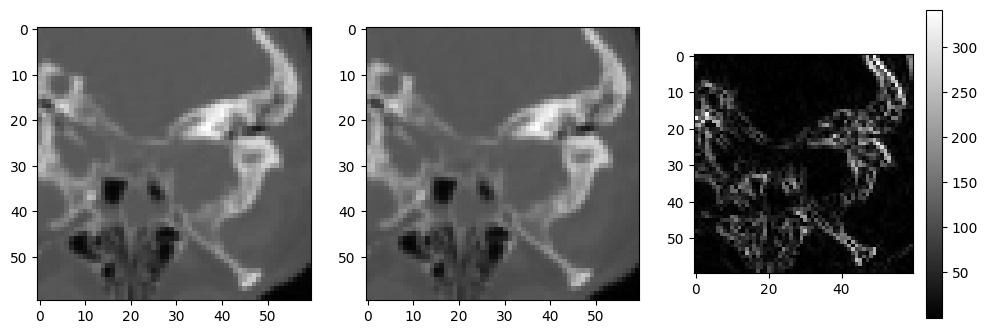

In [11]:
plt.figure(figsize = (12,4))
a = truth_aug[128//2 - 30: 128 // 2 + 30,128//2 - 30: 128 // 2 + 30,:]
b = par_aug_stn[128//2 - 30: 128 // 2 + 30,128//2 - 30: 128 // 2 + 30,:]
plt.subplot(131); plt.imshow(a[:,:,10].T, 'gray')
plt.subplot(132); plt.imshow(b[:,:,10].T, 'gray')
delta = abs(a-b)
plt.subplot(133); plt.imshow(delta[:,:,10].T, 'gray')
plt.colorbar()
print(np.mean(abs(a-b)))
print(a[25,19,10], b[25,19,10])